### Arrhythmia Dataset

#### Number of Samples: 109446, Number of Categories: 5, Sampling Frequency: 125Hz
#### Data Source: MIT-BIH Arrhythmia Dataset, Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load datasets from MIT-BIH
train_data = pd.read_csv('/Users/ohajati/Desktop/ECG/mitbih_train.csv', header=None)  
test_data = pd.read_csv('/Users/ohajati/Desktop/ECG/mitbih_test.csv', header=None)    

# Load datasets from PTBDB
ptbdb_normal = pd.read_csv('/Users/ohajati/Desktop/ECG/ptbdb_normal.csv', header=None)  
ptbdb_abnormal = pd.read_csv('/Users/ohajati/Desktop/ECG/ptbdb_abnormal.csv', header=None)





In [3]:
# Check for missing values and data types
print(train_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
None


In [4]:
#visulizations and represtentations
train_data[187].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

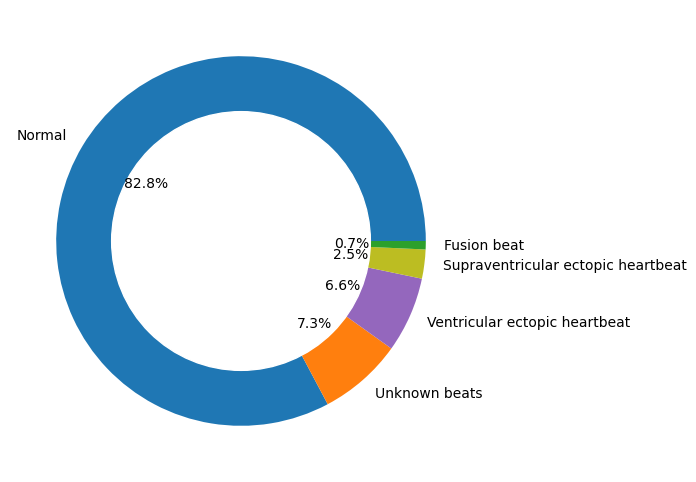

In [5]:
per_class = train_data[187].value_counts()
plt.figure(figsize=(6,6))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['Normal','Unknown beats','Ventricular ectopic heartbeat','Supraventricular ectopic heartbeat','Fusion beat'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

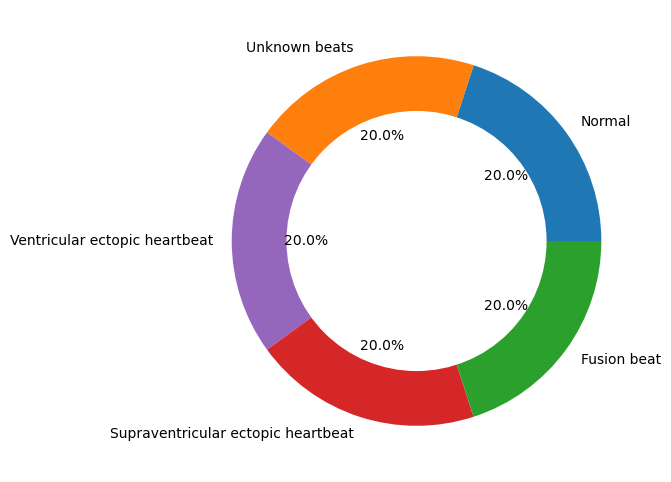

In [6]:
# Create a dictionary to store the resampled DataFrames
resampled_data = {}

# Resample the normal class (0) without replacement
resampled_data[0] = train_data[train_data[187] == 0].sample(n=20000, random_state=42)

# Resample other classes (1, 2, 3, 4) with replacement
for label in range(1, 5):
    class_data = train_data[train_data[187] == label]
    resampled_data[label] = resample(class_data, replace=True, n_samples=20000, random_state=label + 123)

# Combine all resampled DataFrames into one
train_data = pd.concat(resampled_data.values())

# Count the occurrences of each class
per_class = train_data[187].value_counts()

# Plotting the distribution
plt.figure(figsize=(6, 6))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=['Normal','Unknown beats','Ventricular ectopic heartbeat','Supraventricular ectopic heartbeat','Fusion beat'], 
        colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [7]:
classes=train_data.groupby(187,group_keys=False).apply(lambda train_data : train_data.sample(1))
classes

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
5130,1.000000,0.593186,0.034068,0.042084,0.110220,0.074148,0.072144,0.056112,0.060120,0.052104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74484,1.000000,0.980237,0.256917,0.000000,0.118577,0.173913,0.150198,0.213439,0.217391,0.193676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
77358,0.532895,0.473684,0.276316,0.000000,0.075658,0.125000,0.141447,0.161184,0.161184,0.108553,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
81039,0.858195,0.931860,1.000000,0.790055,0.458564,0.255985,0.163904,0.134438,0.114180,0.103131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
86451,0.649924,0.547945,0.447489,0.298326,0.170472,0.074581,0.028919,0.000000,0.030441,0.065449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


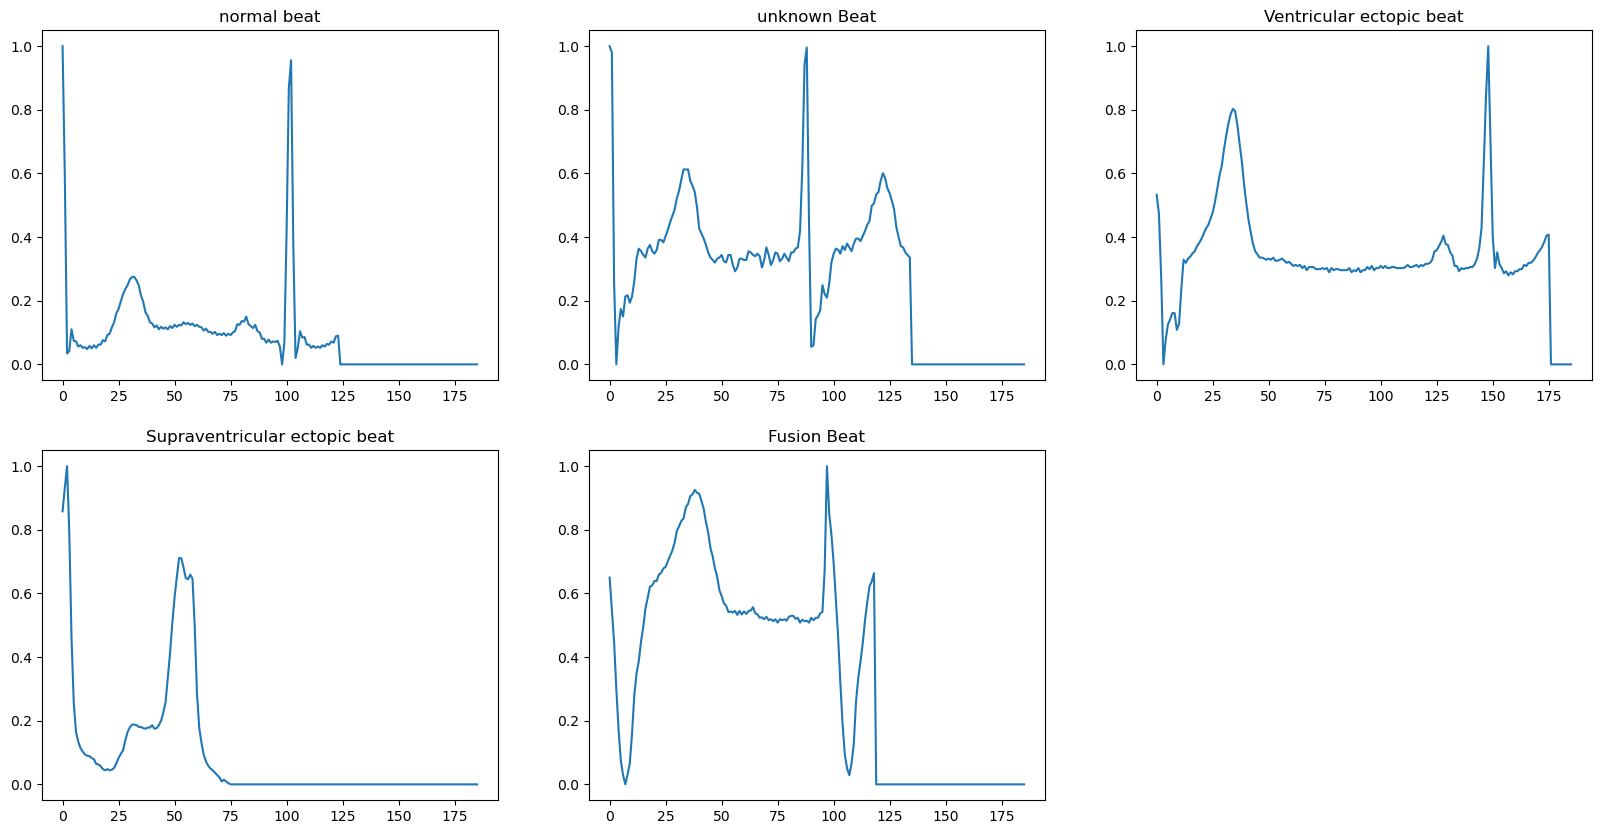

In [8]:
# plotting classes ECG
plt.figure(figsize=(20,10))
# Normal
plt.subplot(2, 3, 1)  
plt.plot(classes.iloc[0,:186])
plt.title('normal beat')
# Unknown
plt.subplot(2, 3, 2)  
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
# Ventricular ectopic beat
plt.subplot(2, 3, 3)  
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
# Supraventricular ectopic beat
plt.subplot(2, 3, 4)  
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
# Fusion
plt.subplot(2, 3, 5)  
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
# show plot
plt.show()

In [12]:
def plot_hist(class_number, size, min_):
    # Get the class data and crop it
    img = train_data.loc[train_data[187] == class_number].values[:, min_:size]
    
    # Flatten the image data
    img_flatten = img.flatten()
    
    # Create a repeated array for x-axis
    final1 = np.tile(np.arange(min_, size), img.shape[0])
    
    # Plot the 2D histogram
    plt.hist2d(final1, img_flatten, bins=(80, 80), cmap=plt.cm.jet)
    plt.colorbar()  # Optional: Add a color bar to the histogram
    plt.show()


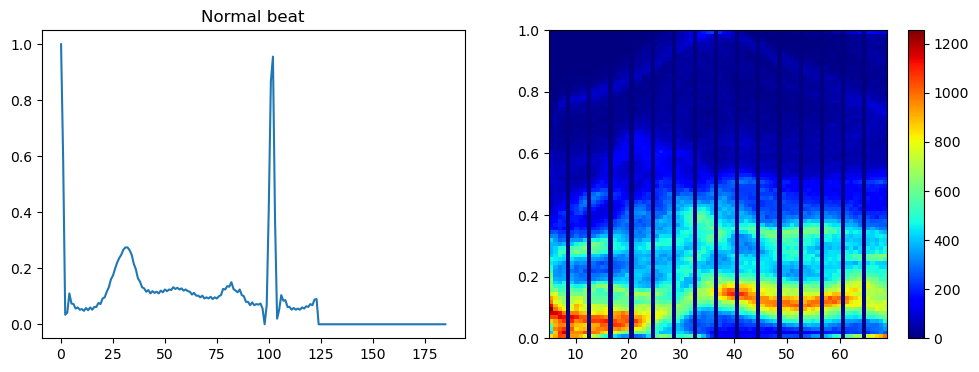

In [13]:
# Normal Beat
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[0,:186])
plt.title('Normal beat')
plt.subplot(1, 2, 2)  
plot_hist(0,70,5)

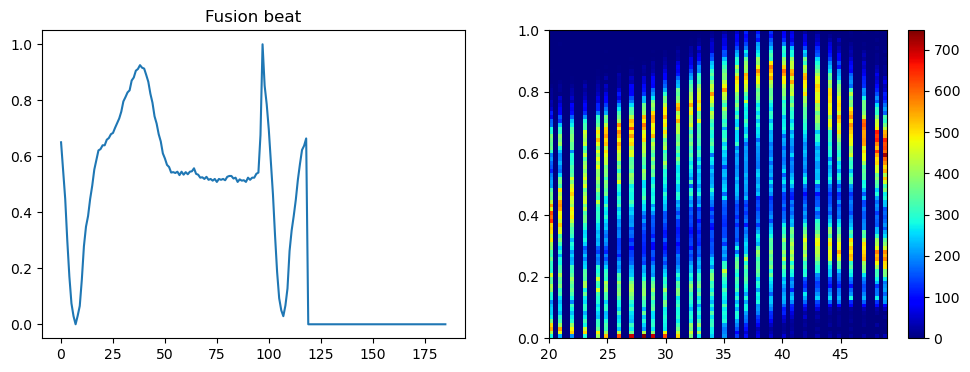

In [17]:
# Normal Beat
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[4,:186])
plt.title('Fusion beat')
plt.subplot(1, 2, 2)  
plot_hist(4,50,20)

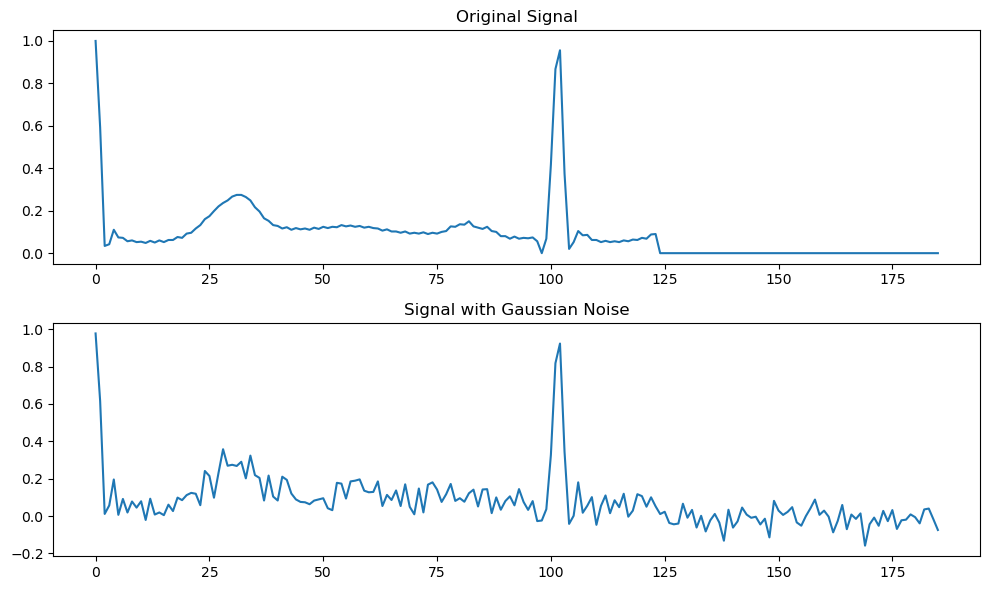

In [18]:
def add_gaussian_noise(signal, mean=0, std_dev=0.05):
    noise = np.random.normal(mean, std_dev, len(signal))
    return signal + noise

# Select the first 186 data points of the first class as the original signal
original_signal = classes.iloc[0, :186]
noisy_signal = add_gaussian_noise(original_signal)

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(original_signal)
plt.title('Original Signal')

plt.subplot(2, 1, 2)
plt.plot(noisy_signal)
plt.title('Signal with Gaussian Noise')

plt.tight_layout()
plt.show()


In [19]:
# Split MIT-BIH training data into features and target
X_train_mitbih = train_data.iloc[:, :-1].values
y_train_mitbih = train_data.iloc[:, -1].values

X_test_mitbih = test_data.iloc[:, :-1].values
y_test_mitbih = test_data.iloc[:, -1].values

In [20]:
y_train_mitbih


array([0., 0., 0., ..., 4., 4., 4.])

In [21]:
# Normalize MIT-BIH data
scaler_mitbih = StandardScaler()
X_train_mitbih_scaled = scaler_mitbih.fit_transform(X_train_mitbih)
X_test_mitbih_scaled = scaler_mitbih.transform(X_test_mitbih)

In [22]:
# Build a neural network model for MIT-BIH
model_mitbih = keras.Sequential([
    layers.Input(shape=(X_train_mitbih_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [23]:
model_mitbih.compile(optimizer='adam',
                     loss='binary_crossentropy',  
                     metrics=['accuracy'])

In [24]:
# Train the model on MIT-BIH data
model_mitbih.fit(X_train_mitbih_scaled, y_train_mitbih, epochs=50, batch_size=32)

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 258us/step - accuracy: 0.2010 - loss: -511206.2188
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step - accuracy: 0.1976 - loss: -12543316.0000
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step - accuracy: 0.1957 - loss: -50943536.0000
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step - accuracy: 0.1788 - loss: -125304792.0000
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step - accuracy: 0.1793 - loss: -241563824.0000
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step - accuracy: 0.1781 - loss: -415859296.0000
Epoch 7/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 242us/step - accuracy: 0.1790 - loss: -643895488.0000
Epoch 8/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step - accuracy: 0.1768 - loss: -946130688.0000
Epoch 9/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 242us/step - accuracy: 0.1793 - loss: -1309271680.0000
Epoch 10/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 258us/step - accuracy: 0.1801 - loss: -1778148480.0000
Epoch 11/50


In [25]:
# Evaluate the model on the MIT-BIH test set
val_loss_mitbih, val_accuracy_mitbih = model_mitbih.evaluate(X_test_mitbih_scaled, y_test_mitbih)
print(f"MIT-BIH Test Loss: {val_loss_mitbih}, Test Accuracy: {val_accuracy_mitbih}")

685/685 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 0.0563 - loss: 91163959296.0000
MIT-BIH Test Loss: 19437899776.0, Test Accuracy: 0.06449844688177109


## Potential reasons for low performances: Model Complexitye, Data Imbalance,Feature Scaling,Learning Rate.

In [38]:
# Network
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=5,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.keras')
    return(model,history)

In [39]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [42]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train_mitbih, num_classes=5)
y_test_one_hot = to_categorical(y_test_mitbih, num_classes=5)


In [44]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history = network(X_train_mitbih_scaled,y_train_one_hot,X_test_mitbih,y_test_one_hot)

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.8849 - loss: 0.3173 - val_accuracy: 0.4572 - val_loss: 1.1176
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9712 - loss: 0.0821 - val_accuracy: 0.2714 - val_loss: 2.5336
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9831 - loss: 0.0514 - val_accuracy: 0.2461 - val_loss: 3.3318
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9868 - loss: 0.0396 - val_accuracy: 0.3980 - val_loss: 2.3383
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9898 - loss: 0.0307 - val_accuracy: 0.5412 - val_loss: 1.5810


Accuracy: 45.72%


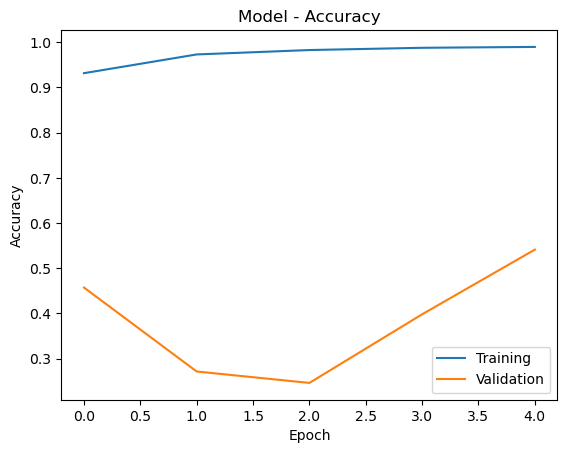

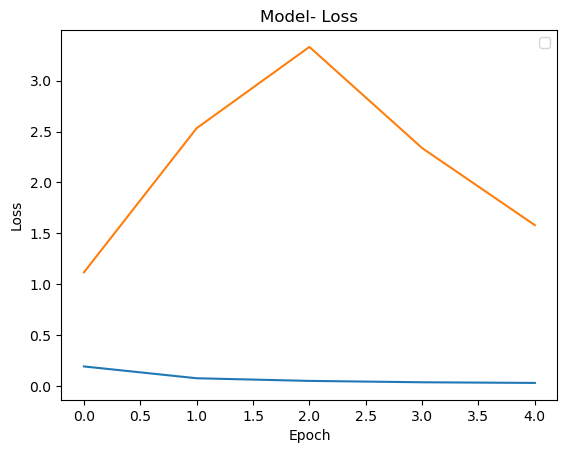

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [46]:
evaluate_model(history,X_test_mitbih,y_test_one_hot,model)
y_pred=model.predict(X_test_mitbih)

## potential issues in  code:
### Data Preprocessing:
##### Ensure that the data is well-preprocessed: handling missing values, normalizing or standardizing the features,  labels are mapped to the expected output classes correctly.
### Imbalanced Classes:
##### I resampled the data to balance the classes, but need to make sure that the resampling method (especially sampling with replacement for some classes) is appropriate for my dataset and doesn't lead to overfitting.
### Model Architecture:
##### The model architecture I am using for the CNN is standard, but I may need to adjust the number of filters, kernel sizes, or layer configurations based on the characteristics of the data. More complex models may not always yield better results if not matched to the dataset's complexity.
### Activation Function:
##### My output layer uses a softmax activation function which is appropriate for multi-class classification. However, i need to ensure that my loss function matches this; I am using categorical_crossentropy, which is correct given that I did one-hot encode my labels.
### Learning Rate:
##### The learning rate in the optimizer can have a significant impact on training. If it's too high, the model may not converge; if it's too low, it may converge too slowly. I might consider using learning rate schedules or adaptive learning rate optimizers.
### Epochs and Early Stopping:
##### i am training for only 5 epochs. Depending on the complexity of the model and data, this may not be sufficient. i need to consider increasing the number of epochs and monitoring the training and validation loss to determine the right stopping point.
### Evaluation Metrics:
##### Accuracy alone may not provide a complete picture, especially in imbalanced datasets. i will consider using precision, recall, F1-score, and confusion matrices for a more detailed analysis.
### Data Augmentation:
###### i will consider additional data augmentation techniques that are appropriate for time series data, which can help improve model robustness.
### Model Complexity:
##### i need to  visualize training vs validation loss/accuracy over epochs to assess if my model is too simple (underfitting) or too complex (overfitting) for the tast. 

## A revised version of this model will be created to address the identified issues.